# Training

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [2]:
#importe un dataframe contenant les images en hsv (car c'etait le format que je pensais le meilleur precedement) et les labels
#l'interet de passer par un .pkl est que c'est plus rapide que de lire toutes les images
import pickle
filename = 'C:\\Users\\Eliaz\\Documents\\GitHub\\Animal-identification-NN\\dataset\\raw-img\\datasetHSV.pkl'
df = pickle.load(open(filename, 'rb'))

In [3]:
working_df = df.copy()
del df
#working_df = working_df[np.isin(working_df['label'], ['cat', 'dog'])]
print(working_df['label'].value_counts())

dog          4863
spider       4821
chicken      3098
horse        2623
butterfly    2112
cow          1866
squirrel     1862
sheep        1820
cat          1668
elephant     1446
Name: label, dtype: int64


In [4]:
print(working_df.columns)

Index(['label', 'img_hsv'], dtype='object')


In [5]:
#resize
size=80
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.resize(x, (size, size)))
print(working_df['img_hsv'].apply(lambda x: x.shape).unique().shape)

(1,)


In [6]:
#hsv to gray
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_HSV2RGB))
#working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY))

In [7]:
#img to array
print(working_df['img_hsv'].shape)
print(working_df['img_hsv'].iloc[0].shape)
print(type(working_df['img_hsv']))
print(type(working_df['img_hsv'].iloc[0]))
working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: x.reshape(size, size, 3))
#working_df['img_hsv'] = working_df['img_hsv'].apply(lambda x: x.reshape(size, size, 1))
X = working_df['img_hsv'].values
X = np.stack(X)
print(X.shape)

(26179,)
(80, 80, 3)
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
(26179, 80, 80, 3)


In [8]:
#transforme le texte des labels en chiffres
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
working_df['label'] = le.fit_transform(working_df['label']) # 0 cat, 1 dog
print(working_df['label'].value_counts())

4    4863
8    4821
2    3098
6    2623
0    2112
3    1866
9    1862
7    1820
1    1668
5    1446
Name: label, dtype: int64


In [9]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, working_df['label'], test_size=0.2)


In [ ]:
#data augmentation de X_train
from keras.preprocessing.image import ImageDataGenerator
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in X_train:
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [10]:
from tensorflow.keras.utils import to_categorical
num = 2
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)
print('turns',y_train.iloc[num],'into', train_Y_one_hot[num])

turns 2 into [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


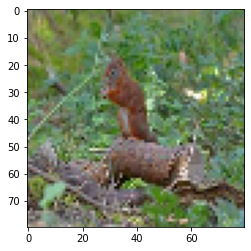

In [35]:
#impression image 
num = 26000
img = X[num]
# rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
plt.imshow(img)

In [12]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

In [13]:
num_classes = train_Y_one_hot.shape[1]
print(num_classes)

10


In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(size,size,X.shape[3])))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
#reseau de neurone "classique" pour la deriere couche cachee
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
#couche de sortie
model.add(Dense(num_classes, activation='softmax'))

In [15]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(),metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 76, 76, 32)        2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 76, 76, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 36, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                    

In [17]:
model.fit(X_train, train_Y_one_hot, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, test_Y_one_hot))

Epoch 1/10
164/164 [==============================] - 121s 731ms/step - loss: 13.8342 - accuracy: 0.2766 - val_loss: 1.7758 - val_accuracy: 0.4112
Epoch 2/10
164/164 [==============================] - 121s 739ms/step - loss: 1.6556 - accuracy: 0.4648 - val_loss: 1.6029 - val_accuracy: 0.4658
Epoch 3/10
164/164 [==============================] - 113s 688ms/step - loss: 1.3446 - accuracy: 0.5535 - val_loss: 1.4694 - val_accuracy: 0.5115
Epoch 4/10
164/164 [==============================] - 127s 775ms/step - loss: 1.0987 - accuracy: 0.6406 - val_loss: 1.5862 - val_accuracy: 0.5036
Epoch 5/10
164/164 [==============================] - 121s 740ms/step - loss: 0.9225 - accuracy: 0.6985 - val_loss: 1.4139 - val_accuracy: 0.5481
Epoch 6/10
164/164 [==============================] - 115s 700ms/step - loss: 0.7671 - accuracy: 0.7521 - val_loss: 1.6664 - val_accuracy: 0.5019
Epoch 7/10
164/164 [==============================] - 111s 677ms/step - loss: 0.6085 - accuracy: 0.8089 - val_loss: 1.4992 

Text(0.5, 0, 'epoch')

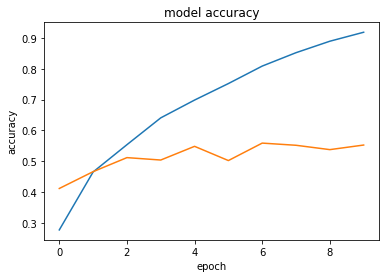

In [18]:
#graph accuracy vs val_accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

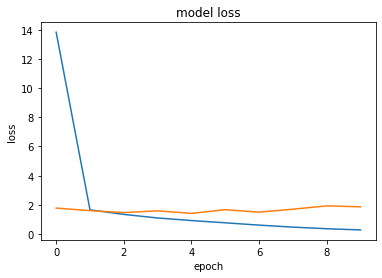

In [19]:
#graph loss vs val_loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [25]:
#save model
model.save('C:\\Users\\Eliaz\\Documents\\GitHub\\Animal-identification-NN\\dataset\\model_rgb_80px.h5')

# Testing

In [26]:
model = tensorflow.keras.models.load_model('C:\\Users\\Eliaz\\Documents\\GitHub\\Animal-identification-NN\\dataset\\model_rgb_80px.h5')

In [27]:
eval = model.evaluate(X_test, test_Y_one_hot, verbose=1)

164/164 [==============================] - 10s 60ms/step - loss: 1.8649 - accuracy: 0.5523


In [28]:
target_names = le.inverse_transform(np.arange(num_classes))
print(target_names)

['butterfly' 'cat' 'chicken' 'cow' 'dog' 'elephant' 'horse' 'sheep'
 'spider' 'squirrel']


In [29]:
#prediction
pred = model.predict(X_test)
#see results by label
pred_label = np.argmax(pred, axis=1)
#print(pred_label)
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_label, target_names=target_names))

              precision    recall  f1-score   support

   butterfly       0.64      0.64      0.64       422
         cat       0.33      0.23      0.28       342
     chicken       0.45      0.74      0.56       594
         cow       0.59      0.34      0.43       365
         dog       0.55      0.62      0.58       977
    elephant       0.66      0.34      0.45       310
       horse       0.63      0.50      0.56       521
       sheep       0.50      0.42      0.45       390
      spider       0.71      0.71      0.71       942
    squirrel       0.40      0.47      0.43       373

    accuracy                           0.55      5236
   macro avg       0.55      0.50      0.51      5236
weighted avg       0.56      0.55      0.55      5236

